In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
from geopy import Nominatim as nom
import re, math

## Model Classes

### Regression

In [2]:
class KNNRegresor():

    def fit(self, X, y):
        self.X = X
        self.y = y.astype(int)

    def predict(self, X, K, epsilon=1e-3):
        N = len(X)
        y_hat = np.zeros(N)

        for i in range(N):
            distsqrd = np.sum((self.X - X[i])**2, axis=1)*epsilon  # Normalize a bit
            idxtK = np.argsort(distsqrd)[:K]
            gamma = np.exp(-distsqrd[idxtK])/(np.exp(-distsqrd[idxtK]).sum() + epsilon)
            y_hat[i] = gamma.dot(self.y[idxtK])

        return y_hat

In [3]:
class simpLinReg():

    def fit(self, X, y):
        self.y = y# y.astype(int)
        self.denom = np.mean(X**2) - np.mean(X)**2
        self.weights = (np.mean(X*y)-(np.mean(X)*np.mean(y)))/self.denom
        self.biases = (np.mean(y)*np.mean(X**2) - np.mean(X)*np.mean(X*y))/self.denom
    
    def predict(self, X, y=[], show=0):
        # if y == []: y = self.y  # May start create size mismatch issue 
        if y == []: y = self.y[:,len(X)]
        y_hat = self.weights*X + self.biases
        if show:
            plt.figure()
            plt.scatter(X, y, s=8)
            plt.plot(X, y_hat, c="#FF0070")
        return y_hat

In [4]:
class MMLinReg():

    def fit(self, X, y):
        self.W = np.linalg.solve(X.T@X, X.T@y)

    def predict(self, X):
        # return np.matmul(X, self.W)
        return X@self.W

In [5]:
class OurLinearRegression():

    def fit(self, X, y, alpha=1e-3, epochs=1e3, show=0):
        epochs = int(epochs)
        N, D = X.shape
        Y = y
        gradient = 1/N
        alphaG = alpha*gradient
        
        # Stochastic GD
        self.W = np.random.randn(D)             # Init weights
        J = np.zeros(epochs)                    # Init loss func storage
        for epoch in range(epochs):             # GD steps
            Y_hat = self.predict(X)             # y_hats
            J[epoch] = OLS(Y, Y_hat, N)         # Calculating the error
            self.W -= alphaG*(X.T@(Y_hat-Y))    # Weight update rule
        if show: 
            self.show_curve(J)

    def predict(self, X):
        return X@self.W

    def show_curve(self, J):
        plt.figure()
        plt.plot(J)
        plt.xlabel("epochs")
        plt.ylabel("$\mathcal{J}$")
        plt.title("Training Curve")
        plt.show()

### Classification

In [6]:
class KNNClassifier():

    def fit(self, X, y):
        self.X = X
        self.y = y.astype(int)

    def predict(self, X, K, epsilon=1e-3):
        N = len(X)
        y_hat = np.zeros(N)
        # Calculating distances from one point to every other point
        for i in range(N):
            dist2 = np.sum((self.X-X[i])**2, axis=1)  # List of distances
            idxtK = np.argsort(dist2)[:K]    # Indecies in order from smallest to largest up to K
            gamma = 1/(np.sqrt(dist2[idxtK]+epsilon))
            y_hat[i] = np.bincount(self.y[idxtK], weights=gamma).argmax()
        return y_hat

### And other funcs

In [7]:
def acc(y, y_hat):
  return np.mean(y==y_hat)

def minmax_normalize_dataframe(df):
    df = df.copy
    return (df-df.min())/(df.max()-df.min())

def minmax_norm_feature(df, feature):
    df = df.copy()
    max_value = df[feature].max()
    min_value = df[feature].min()
    df[feature] = (df[feature] - min_value) / (max_value - min_value)
    return df

def OLS(Y, Y_hat, N):
    return (1/(2^N)*np.sum((Y-Y_hat)**2))

def R2(Y, Y_hat):
    return (1-(np.sum((Y-Y_hat)**2)/np.sum((Y-np.mean(Y))**2)))

def get_geopy(address):
    geolocator = nom(user_agent="tfClan")
    location = geolocator.geocode(address)
    return location

def get_coords(address, decimals=6):
    geo = get_geopy(address).raw
    a = np.array([[float(geo['lon']), float(geo['lat'])]])
    return np.round(a, decimals)

def split_data(numpy_array, test_size_percentage=0.1):
    split_at = math.floor(len(numpy_array)*test_size_percentage)
    np.random.shuffle(numpy_array)
    test = numpy_array[:split_at,:]
    train = numpy_array[split_at:,:]
    return train, test

def train_test_split(df, train_feats, target_feat, test_size_percentage=0.1, seed=None):
    df = df.copy()
    ss = np.random.randint(1, 200, size=1) if seed == None else seed
    print(ss)
    test = df.sample(frac=test_size_percentage, axis=0, random_state=ss)
    train = df.drop(index=test.index)

    X_train, y_train = train.loc[:, train_feats], train.loc[:, target_feat]
    X_test, y_test = test.loc[:, train_feats], test.loc[:, target_feat]
    
    X_train, y_train = X_train.to_numpy(), y_train.to_numpy().reshape(-1,)
    X_test, y_test = X_test.to_numpy(), y_test.to_numpy().reshape(-1,)
    return X_train, y_train, X_test, y_test

## From HW1

In [8]:
df = pd.read_csv('/content/raw_house_data.csv')
print(df.shape)

(5000, 16)


In [9]:
# Remove duplicated rows if they exist
df.drop_duplicates()
print(df.shape)

(5000, 16)


In [10]:
# Convert all 'None' values to nan
cols = ['MLS', 'sold_price', 'zipcode', 'lot_acres', 'taxes', 'year_built',
       'bedrooms', 'bathrooms', 'sqrt_ft', 'garage', 'kitchen_features',
       'fireplaces', 'floor_covering', 'HOA']
for i in cols:
  df[i].replace('None', np.nan, inplace=True)
df.head(3)

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.0,5272.00,1941,13,10,10500,0,"Dishwasher, Freezer, Refrigerator, Oven",6.0,"Mexican Tile, Wood",0
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.0,10422.36,1997,2,2,7300,0,"Dishwasher, Garbage Disposal",5.0,"Natural Stone, Other",0
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.0,10482.00,1997,2,3,NaN,NaN,"Dishwasher, Garbage Disposal, Refrigerator",5.0,"Natural Stone, Other: Rock",NaN


ASSUMPTION: I am assuming nan values for ['HOA', 'fireplaces', 'garage'] denotes that the property doesnt have the corresponding item. I am therefore converting those nan values to 0 to represent my assumption. 

In [11]:
# With that assumption, I will change those nan values to 0
cols_nan_to_0 = ['HOA', 'fireplaces', 'garage', 'lot_acres']
for i in cols_nan_to_0:
  df[i].replace(np.nan, 0, inplace=True)

In [12]:
# With that assumption, I will change those nan values to None
cols_nan_to_none = ['kitchen_features', 'floor_covering']
for i in cols_nan_to_none:
  df[i].replace(np.nan, None, inplace=True)

In [13]:
(df.isnull().sum().sum())/5000

0.0124

Only 2% of the data contains missing values at this point. Being that it is less than 5% of the total data, I think it is safe to remove them. 

In [14]:
df = df.dropna()
df.shape

(4944, 16)

In [15]:
df.dtypes

MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms            object
sqrt_ft              object
garage               object
kitchen_features     object
fireplaces          float64
floor_covering       object
HOA                  object
dtype: object

In [16]:
# Converting the object types to a numerical type
df.bathrooms = df.bathrooms.astype(float)
df.sqrt_ft = df.sqrt_ft.astype(float)
df.garage = df.garage.astype(float).astype(int)
df.fireplaces = df.fireplaces.astype(int)
df.HOA = df.HOA.replace(',','', regex=True)
df.HOA = df.HOA.astype(float)
df.dtypes

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms           float64
sqrt_ft             float64
garage                int64
kitchen_features     object
fireplaces            int64
floor_covering       object
HOA                 float64
dtype: object

Now that the dtypes have been dealth with I will create another dataframe to start cleaning another aspect of the data.

In [17]:
# kitchen_items = set([])
# for i in df2['kitchen_features'].unique():
#   for item in i.split(','):
#     kitchen_items.add(item.strip(' '))
# kitchen_items = sorted(kitchen_items)
# for i in kitchen_items:
#   print(i)

After seeing how dirty the 'kitchen_features' data is I decided to remove it until further notice. I think it can be processed and added to the dataset using a one-hot-encoding style in the future, but until I develope a method for doing so I believe it is better to leave it out of the dataset. 

In [18]:
# df3 = df2.drop(['kitchen_features'], axis=1)
# print(df3.shape)
# df3.head(3)

In [19]:
# floor_items = set([])
# for i in df3['floor_covering'].unique():
#   for item in i.split(','):
#     floor_items.add(item.strip(' '))
# floor_items = sorted(floor_items)
# for i in floor_items:
#   print(i)

I am removing floor_coverings for the same reason I removed kitchen_items

In [20]:
# df3 = df3.drop(['floor_covering'], axis=1)
# print(df3.shape)
# df3.head(3)

I believe the important information in the HOA column is whether a property does or doesn't have an attached HOA, so I one-hot-encoded the HOA column to represent that. I think this is a better representation because some area's will naturally have a higher population, thus a larger HOA, and that could skew the results.

In [21]:
df.HOA = df.HOA.apply(lambda x: 1 if x > 0.0 else 0)
df.HOA.unique()

array([0, 1])

I am creating two columns ['price_per_sqft', 'price_per_acre'] because I believe they will be good price estimators. Before I can do that I will check & remove rows where either of those columns are 0 as long as I don't end up removing more than 5% of the original data. 

In [22]:
# print(df[df['lot_acres'].apply(lambda x: x == 0.0)].shape)
print(df[df['sqrt_ft'].apply(lambda x: x == 0.0)].shape)

(0, 16)


In [23]:
df = df[~df['sqrt_ft'].apply(lambda x: x == 0.0)]

Since it was only 35 rows I know I can remove them without going over my 5% limit. In total, I removed a little less than 3% of the data. 

In [24]:
df['pp_sqft'] = round(df['sold_price']/df['sqrt_ft'], 2)
df = df.drop("MLS", axis=1)
df.head()

,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA,pp_sqft
0,5300000.0,85637,-110.378200,31.356362,2154.00,5272.00,1941,13,10.0,10500.0,0,"Dishwasher, Freezer, Refrigerator, Oven",6,"Mexican Tile, Wood",0,504.76
1,4200000.0,85646,-111.045371,31.594213,1707.00,10422.36,1997,2,2.0,7300.0,0,"Dishwasher, Garbage Disposal",5,"Natural Stone, Other",0,575.34
3,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,9019.0,4,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4,"Ceramic Tile, Laminate, Wood",0,498.95
4,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,6396.0,3,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5,"Carpet, Concrete",1,533.37
5,3250000.0,85718,-110.910593,32.339090,1.67,27802.84,1999,3,4.0,6842.0,3,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5,"Natural Stone, Wood, Other",1,475.01


## HW2 Start

### More cleaning

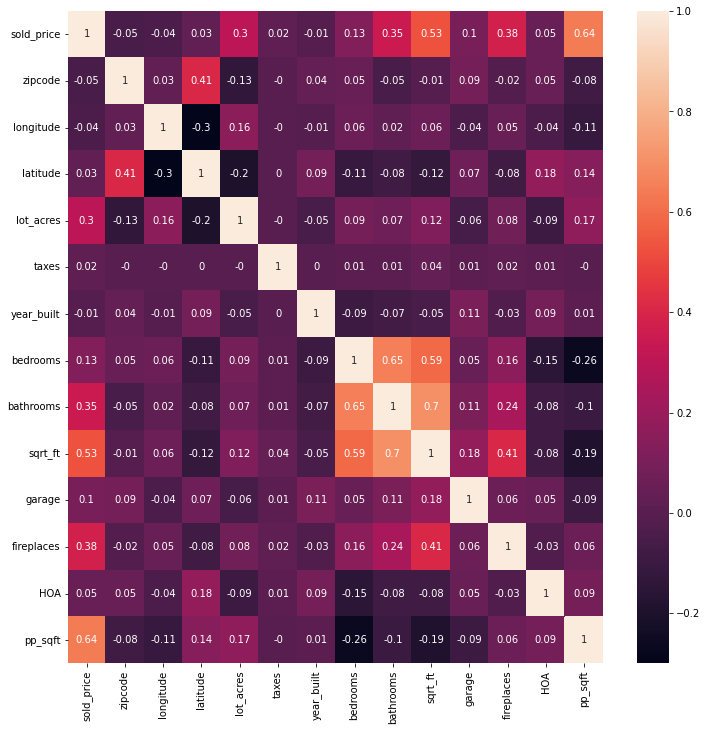

In [25]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr().round(2), annot=True)

#### Outlier removals

In [26]:
def charts(frame, col, cut_off):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    ax1.hist(df[col])
    sns.boxplot(x=df[col], ax=ax2)

    ax3.hist(df[df[col]<=cut_off][col])
    sns.boxplot(x=df[df[col]<=cut_off][col], ax=ax4)

In [27]:
df.columns

Index(['sold_price', 'zipcode', 'longitude', 'latitude', 'lot_acres', 'taxes',
       'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage',
       'kitchen_features', 'fireplaces', 'floor_covering', 'HOA', 'pp_sqft'],
      dtype='object')

In [28]:
df.describe(include=[np.number])

,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,fireplaces,HOA,pp_sqft
count,4.944000e+03,4944.000000,4944.000000,4944.000000,4944.000000,4.944000e+03,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000
mean,7.757358e+05,85724.128236,-110.910942,32.314540,4.270884,9.444989e+03,1992.259506,3.935477,3.824939,3716.366828,2.806837,1.883495,0.723301,212.527221
std,3.160465e+05,36.803079,0.120604,0.169380,45.851750,1.739144e+05,65.830904,1.160795,1.318048,1120.683515,1.200557,1.135463,0.447412,66.730359
min,1.690000e+05,85118.000000,-112.520168,31.356362,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1100.000000,0.000000,0.000000,0.000000,24.540000
25%,5.850000e+05,85718.000000,-110.978590,32.280278,0.580000,4.819410e+03,1987.000000,3.000000,3.000000,3047.000000,2.000000,1.000000,0.000000,175.500000
50%,6.790000e+05,85737.000000,-110.922462,32.319136,0.980000,6.248770e+03,1999.000000,4.000000,4.000000,3512.000000,3.000000,2.000000,1.000000,202.595000
75%,8.400000e+05,85750.000000,-110.858578,32.396124,1.740000,8.106153e+03,2006.000000,4.000000,4.000000,4130.250000,3.000000,3.000000,1.000000,234.100000
max,5.300000e+06,86323.000000,-109.454637,34.927884,2154.000000,1.221508e+07,2019.000000,36.000000,36.000000,22408.000000,30.000000,9.000000,1.000000,1208.330000


(array([1.910e+02, 1.980e+03, 1.823e+03, 8.580e+02, 5.600e+01, 1.900e+01,
        9.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <a list of 10 Patch objects>)

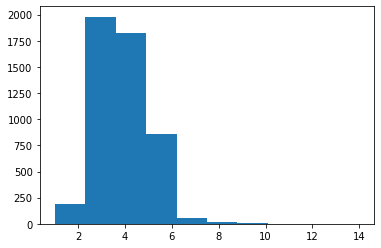

In [29]:
plt.figure()
plt.hist(df[df.bathrooms<15].bathrooms)

In [30]:
df[df.bathrooms>=15]

,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA,pp_sqft
35,2495000.0,85637,-110.740635,31.720431,131.00,1220.32,0,13,15.0,13000.0,0,"Compactor, Dishwasher, Freezer, Garbage Dispos...",4,"Carpet, Ceramic Tile, Mexican Tile",0,191.92
635,895000.0,85749,-110.799667,32.253627,11.57,26110.00,1948,19,18.0,12154.0,0,"Dishwasher, Garbage Disposal, Pantry: Walk-In,...",3,"Carpet, Mexican Tile, Other: Multiple Types",0,73.64
2111,550000.0,85645,-111.047350,31.701117,50.00,25113.45,1936,36,35.0,22408.0,0,Countertops: Stainless,1,"Ceramic Tile, Mexican Tile",0,24.54
3277,695000.0,85645,-111.047260,31.701407,50.00,6520.66,1936,36,35.0,21915.0,0,Refrigerator,1,"Ceramic Tile, Mexican Tile",0,31.71
4663,575359.5,85641,-110.687945,32.081978,1.07,625.00,2019,5,36.0,3720.0,3,"Dishwasher, Double Sink, Garbage Disposal, Gas...",1,"Carpet, Ceramic Tile",0,154.67


(array([3.993e+03, 9.150e+02, 3.000e+01, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <a list of 10 Patch objects>)

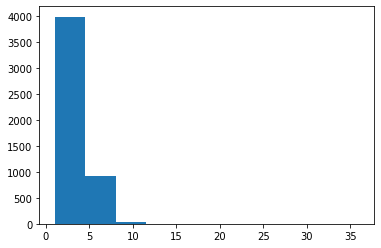

In [31]:
# df = df[df.bathrooms<15]
plt.figure()
plt.hist(df.bathrooms)

(array([1.587e+03, 3.251e+03, 8.800e+01, 1.000e+01, 4.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

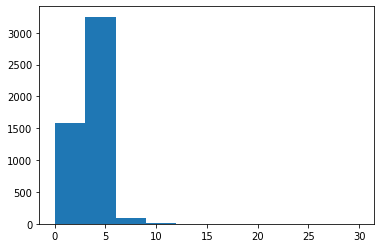

In [32]:
plt.figure()
plt.hist(df.garage)

In [33]:
df[df.garage>10]

,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA,pp_sqft
140,1695000.0,85742,-111.034883,32.441422,4.58,19488.82,2004,6,6.0,6923.0,15,"Dishwasher, Double Sink, Garbage Disposal, Ind...",5,Natural Stone,0,244.84
905,825000.0,85745,-111.103561,32.264041,24.92,16165.77,2005,5,6.0,5937.0,22,"Dishwasher, Garbage Disposal, Microwave, Oven",3,"Carpet, Concrete",0,138.96
1505,817034.0,85755,-110.984403,32.464579,0.24,416.45,2016,2,3.0,2880.0,30,"Dishwasher, Freezer, Garbage Disposal, Refrige...",0,"Carpet, Ceramic Tile",1,283.69
1560,785000.0,85749,-110.756365,32.268453,8.77,9313.08,1975,4,3.0,3598.0,12,"Compactor, Desk, Dishwasher, Double Sink, Elec...",3,"Carpet, Ceramic Tile",0,218.18
2713,685000.0,85749,-110.755687,32.303589,3.31,6845.07,2003,3,4.0,2854.0,12,"Dishwasher, Electric Range, Garbage Disposal, ...",1,"Carpet, Ceramic Tile, Wood",0,240.01
2961,620000.0,85641,-110.728920,31.920157,8.37,5128.38,2001,3,3.0,3248.0,12,"Desk, Dishwasher, Double Sink, Electric Range,...",1,Ceramic Tile,0,190.89
3974,540000.0,85749,-110.780466,32.251520,1.49,4034.02,1989,4,4.0,3033.0,11,"Dishwasher, Double Sink, Garbage Disposal, Laz...",1,Natural Stone,0,178.04
4455,550000.0,85730,-110.756556,32.181148,9.10,6656.60,1960,7,5.0,4072.0,20,"Compactor, Dishwasher, Garbage Disposal, Refri...",2,"Carpet, Ceramic Tile, Mexican Tile, Other",0,135.07
4759,560000.0,85742,-111.054465,32.383574,9.55,9348.83,1982,4,5.0,4282.0,13,"Dishwasher, Garbage Disposal, Gas Range, Lazy ...",1,"Carpet, Ceramic Tile, Natural Stone",0,130.78


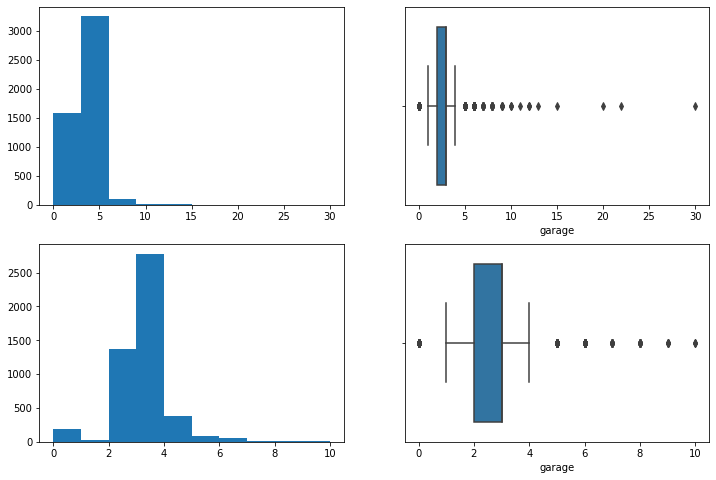

In [34]:
charts(df, "garage", 10)

In [35]:
# df = df[df.garage<10]

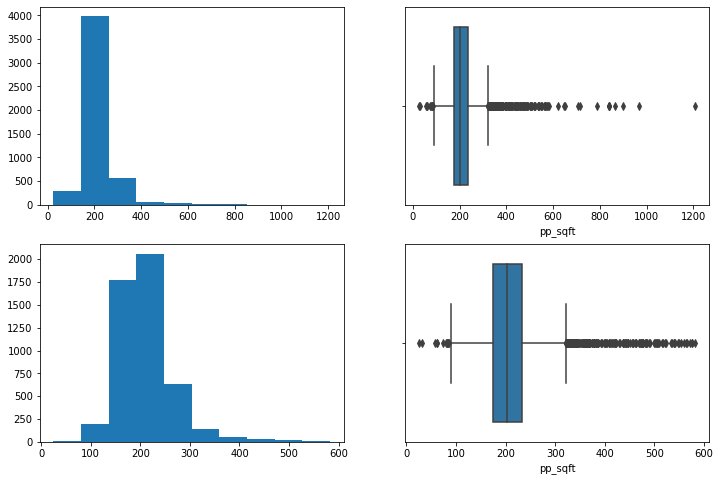

In [36]:
charts(df, "pp_sqft", 600)

In [37]:
df[df.pp_sqft>600]
# df = df[df.pp_sqft<600]

,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA,pp_sqft
8,3700000.0,85718,-110.912156,32.343601,6.73,25094.39,2002,5,7.0,5238.0,3,"Compactor, Dishwasher, Freezer, Garbage Dispos...",1,"Carpet, Natural Stone, Wood, Other",1,706.38
14,3000000.0,85739,-110.883068,32.508778,0.00,29669.00,2008,3,3.0,3095.0,0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",3,"Natural Stone, Wood",1,969.31
15,2600000.0,85739,-110.883252,32.507699,0.00,18044.00,2008,3,3.0,3095.0,0,"Dishwasher, Freezer, Garbage Disposal, Refrige...",3,"Natural Stone, Wood",0,840.06
18,2600000.0,85739,-110.883239,32.509040,0.00,17567.18,2008,3,3.0,3095.0,0,"Dishwasher, Refrigerator, Microwave, Oven",3,"Natural Stone, Wood",0,840.06
20,2600000.0,85739,-110.883065,32.508778,0.00,8753.35,2008,3,3.0,3095.0,0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",3,"Natural Stone, Wood",0,840.06
26,2600000.0,85739,-110.883055,32.508861,0.15,30072.26,2008,3,3.0,3095.0,0,"Dishwasher, Double Sink, Garbage Disposal, Gas...",3,"Natural Stone, Wood",1,840.06
29,2500000.0,85609,-110.095713,32.057222,1048.18,2441.60,1985,2,2.0,2895.0,0,"Refrigerator, Oven",1,"Carpet, Mexican Tile, Other",0,863.56
49,1800000.0,86024,-111.228462,34.596971,59.30,4509.90,2003,2,3.0,1999.0,2,"Dishwasher, Garbage Disposal, Gas Range, Refri...",1,"Carpet, Wood, Other: Brick",0,900.45
53,2150000.0,85739,-110.883660,32.509721,0.00,19060.81,2008,2,3.0,2729.0,0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",2,"Natural Stone, Wood",1,787.83
58,2117552.0,85658,-111.092958,32.472956,0.63,1340.87,2014,3,4.0,3276.0,2,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",2,"Carpet, Natural Stone",1,646.38


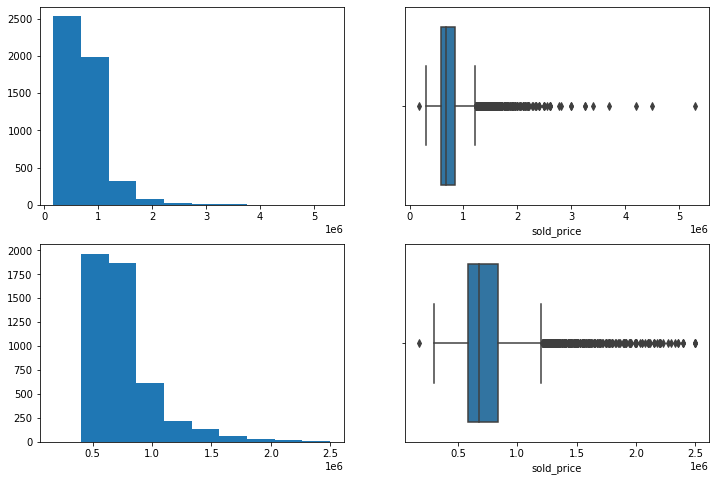

In [38]:
df[df.sold_price>2500000]
# df = df[df.sold_price<2500001]
charts(df, "sold_price", 2500000)

In [39]:
# 'Outliers' removed after glancing at the scatter plots
df = df[df.lot_acres < 1000]
df = df[df.taxes < 1200000]
df = df[df.year_built != 0]
df = df[df.bedrooms < 15]
df = df[df.bathrooms < 20]
df = df[df.sqrt_ft < 15000]
df = df[df.garage < 15]
df = df[df.sold_price < 3000000]

### Feature engineering

#### New features

In [40]:
df["avg_room_size"] = (df["sqrt_ft"]//(df.bedrooms + df.bathrooms)).astype(int)
df["home_age"] = (2022 - df.year_built)
df["bed_bath"] = (df.bedrooms // df.bathrooms).astype(int)
df["abs_lon"] = df.longitude.abs()
df["abs_lat"] = df.latitude.abs()

#### Dealing with kitchen & floor

##### Floor

In [41]:
def converting_floor(column):
    unique_items = set([])
    item_counts = dict()
    for i in column:
        for item in i.split(','):
            item = item.strip().lower()
            if item in item_counts: 
                item_counts[item] += 1
            else: 
                item_counts[item] = 1
            unique_items.add(item)
    return sorted(unique_items), item_counts

def regx_filter_keys(d,a):
    drops = []
    for s in a:
        for key, val in d.items():
            if not s==key and re.search(s, key):
                if s in d.keys():
                    d[s] += val
                    drops.append(key)
                else:
                    d[s] = val
                    d.pop(key)
    for _ in drops:
        if _ in d.keys():
            d.pop(_)
    return d 

def combine_keyvals(d,key,a):
    for _ in a:
        d[key] += d[_]
        d.pop(_)
    return d

def reg_count(d,s):
    occurences = {}
    for key,val in d.items():
        if re.search(s, key):
            occurences[key] = val
    return occurences

In [42]:
# floor_items, item_counts = converting_floor(df['floor_covering'].unique())
floor_items, item_counts = converting_floor(df['floor_covering'])
print(len(floor_items))

96


In [43]:
temp = ["carpet", "ceramic tile", "wood", "natural stone", "concrete", 
        "mexican tile", "laminate", "vinyl", "porcelain", "travertine", "other"]
a = regx_filter_keys(item_counts, temp)
a = combine_keyvals(a, "other", ["granite", "indoor/outdoor"])
sorted_a = sorted(a.items(), reverse=1, key=lambda k:(k[1], k[0]))
for x in sorted_a:
    print(x)

('carpet', 3466)
('ceramic tile', 2487)
('natural stone', 1486)
('wood', 1234)
('concrete', 754)
('mexican tile', 644)
('other', 456)
('laminate', 86)
('vinyl', 59)
('porcelain', 59)
('travertine', 34)


In [44]:
test = df.copy()

def convert_floor(x):
    items = set([])
    for item in x.split(','):
        items.add(item.strip(' ').lower())
    ar = set([])
    for item in items:
        if item in temp:
            ar.add(item)
        elif item == "granite" or item == 'indoor/outdoor':
            ar.add("other")
    return list(ar)

df.floor_covering = test.floor_covering.apply(lambda x: convert_floor(x))

#### Golf Courses?

In [45]:
gcs = [
    "600 S Alvernon Way, Tucson, AZ 85711", 
    "6601 E Speedway Blvd, Tucson, AZ 85710", 
    "1400 W Speedway Blvd, Tucson, AZ 85745", 
    "3600 N Silverbell Rd, Tucson, AZ 85745", 
    "3645 W Starr Pass Blvd, Tucson, AZ 85745",
    "3660 E Sunrise Dr, Tucson, AZ 85718",
    "8251 E Irvington Rd, Tucson, AZ 85730",
    "9777 E Sabino Greens Dr, Tucson, AZ 85749",
    "5655 W Valencia Rd, Tucson, AZ 85757",
    "8900 E 29th St., Tucson, AZ 85710",
    "6051 E 14th St, Tucson, AZ 85711",
    "2727 W Club Dr, Tucson, AZ 85742",
    "2950 N Camino Principal, Tucson, AZ 85715",
    "9101 N Thornydale Rd, Tucson, AZ 85742"
]

d = {'lat': [], 'lon': []}
for i in gcs:
    raw = get_geopy(i).raw
    d['lat'].append(float(raw['lat']))
    d['lon'].append(float(raw['lon']))
golfs = pd.DataFrame.from_dict(d)
print(golfs.to_dict())

{'lat': {0: 32.2170556, 1: 32.239303699999994, 2: 32.23894725, 3: 32.269593, 4: 32.21276061974293, 5: 32.315879249999995, 6: 32.168690100000006, 7: 32.2996506, 8: 32.13120205, 9: 32.196329500000004, 10: 32.21703329685896, 11: 32.357150399999995, 12: 32.2503589, 13: 32.37498295}, 'lon': {0: -110.91396096077594, 1: -110.85158639073597, 2: -110.99823717986445, 3: -111.0248, 4: -111.04347151432609, 5: -110.90835985236096, 6: -110.81192982094552, 7: -110.78393175284572, 8: -111.08673277753888, 9: -110.80327593615809, 10: -110.86336374912842, 11: -111.02007726737105, 12: -110.8487721, 13: -111.05583525755708}}


In [46]:
from geopy.distance import geodesic

dcs_dict = {'lat': {0: 32.2170556, 1: 32.239303699999994, 2: 32.23894725, 3: 32.269593, 4: 32.21276061974293, 5: 32.315879249999995, 6: 32.168690100000006, 7: 32.2996506, 8: 32.13120205, 9: 32.196329500000004, 10: 32.21703329685896, 11: 32.357150399999995, 12: 32.2503589, 13: 32.37498295}, 'lon': {0: -110.91396096077594, 1: -110.85158639073597, 2: -110.99823717986445, 3: -111.0248, 4: -111.04347151432609, 5: -110.90835985236096, 6: -110.81192982094552, 7: -110.78393175284572, 8: -111.08673277753888, 9: -110.80327593615809, 10: -110.86336374912842, 11: -111.02007726737105, 12: -110.8487721, 13: -111.05583525755708}}
golf_df = pd.DataFrame(data=dcs_dict)

def golfers(golf_df, X):
    dist_df = X[['latitude', 'longitude']].copy()
    for i, v in golf_df.iterrows():
        gc = (v['lat'], v['lon'])
        lst = []
        for ii, vv in dist_df.iterrows():
            h = (vv['latitude'], vv['longitude'])
            dmi = geodesic(gc, h).mi
            lst.append(dmi)
        dist_df[f'GC{i}'] = lst
    return dist_df


In [47]:
# dist_df = golfers(golf_df, binned_df)

In [48]:
# dist_df['sold_pice'] = binned_df.sold_price
# first_col = dist_df.pop("sold_pice")
# dist_df.insert(0, "sold_price", first_col)
# lat, lot = dist_df.pop("latitude"), dist_df.pop("longitude")
# lot
# gc9 = dist_df.pop("GC9")
# dist_df

In [49]:
# sold_price correlations to golf course distances
# corrmat = dist_df.corr()
# cols = corrmat.nlargest(len(dist_df.columns), 'sold_price')['sold_price'].index
# cm = np.corrcoef(dist_df[cols].values.T)

# # Heatmap
# plt.figure(figsize=(10, 10))
# ax = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 12}, cmap="flare")
# ax.set_yticklabels(cols.values, rotation=0)
# ax.set_xticklabels(cols.values, rotation=60)
# ax.set_title("Correlation Heatmap: sold_price", fontsize=18)

In [50]:
# binned_df["GC6"] = dist_df.GC6

### Binning

In [51]:
binned_df = pd.DataFrame(df[["sold_price", "pp_sqft", "longitude", "latitude", "zipcode", "bathrooms", "bedrooms", "sqrt_ft", "abs_lon", "abs_lat"]])

In [52]:
def bin(col, dist):
    return np.round(col / dist) * dist

def bin_int_column(X, col_name, bin_name, bin_size):
    X = X.copy()
    mid = int(round(bin_size/2,2))
    for i, v in X.iterrows():
        value = v[col_name]
        rem = value % bin_size
        laps = int((value - rem)/bin_size)
        if rem > mid: laps += 1
        X.at[i, bin_name] = laps
    return X

def bin_int_column2(X, col_name, bin_name, bin_sz, bin_start, bin_stop):
    X = X.copy()
    mid = int(round(bin_sz/2,2))
    min_bin, max_bin = bin_start//bin_sz, bin_stop//bin_sz
    for i, v in X.iterrows():
        value = v[col_name]
        rem = value % bin_sz
        laps = int((value - rem)/bin_sz)
        if rem > mid: 
            laps += 1
        if laps <= min_bin:
            laps = min_bin
        elif laps > max_bin:
            laps = max_bin
        X.at[i, bin_name] = laps
    return X

##### Binning based on pp_sqft

In [53]:
# print(binned_df.pp_sqft.describe())
# binned_df.pp_sqft.plot(kind="hist")
# binned_df[binned_df.pp_sqft < 600].pp_sqft.plot(kind="hist")

In [54]:
binned_df = binned_df[binned_df.pp_sqft < 1000]

In [55]:
binned_df = bin_int_column(binned_df, "pp_sqft", "pp_sqft_bin", 100)
binned_df.pp_sqft_bin = binned_df.pp_sqft_bin.astype(int)

1     417
2    3650
3     723
4      75
5      36
6       9
7       2
8       5
9       1
Name: pp_sqft_bin, dtype: int64


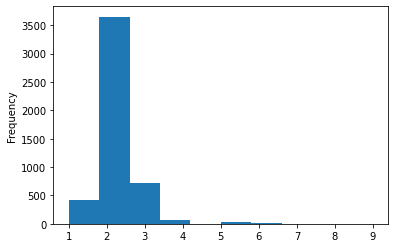

In [56]:
print(binned_df.pp_sqft_bin.value_counts().sort_index())
binned_df.pp_sqft_bin.plot(kind="hist")

In [57]:
# Testing smaller bins
binned_df2 = binned_df.copy()
binned_df2 = bin_int_column2(binned_df2, "pp_sqft", "pp_sqft_bin", 25, 100, 450)
binned_df2.pp_sqft_bin.value_counts().sort_index()

4       44
5      169
6      514
7     1007
8     1167
9      872
10     497
11     281
12     138
13      78
14      36
15      30
16      11
17      11
18      63
Name: pp_sqft_bin, dtype: int64

In [58]:
# binned_df2.loc[(binned_df2.pp_sqft_bin == 13), 'pp_sqft_bin'] = 12
# binned_df2.loc[(binned_df2.pp_sqft_bin >= 14), 'pp_sqft_bin'] = 14
# binned_df2.loc[(binned_df2.pp_sqft_bin == 15), 'pp_sqft_bin'] = 14
# binned_df2.loc[(binned_df2.pp_sqft_bin == 16), 'pp_sqft_bin'] = 14
# binned_df2.loc[(binned_df2.pp_sqft_bin == 17), 'pp_sqft_bin'] = 14
# binned_df2.loc[(binned_df2.pp_sqft_bin >= 18), 'pp_sqft_bin'] = 15
# binned_df2.pp_sqft_bin.value_counts().sort_index()

In [59]:
print(binned_df2.pp_sqft_bin.value_counts().sort_index())
# binned_df2.pp_sqft_bin.plot(kind="hist")

4       44
5      169
6      514
7     1007
8     1167
9      872
10     497
11     281
12     138
13      78
14      36
15      30
16      11
17      11
18      63
Name: pp_sqft_bin, dtype: int64


#### Final bins

## Models

### The data

In [60]:
# binned_df['avg_room_size'] = (df["sqrt_ft"]//(df.bedrooms + df.bathrooms)).astype(int)
# df["pp_sqft_bin"] = binned_df['pp_sqft_bin']
# first_col = df.pop("pp_sqft_bin")
# df.insert(0, "pp_sqft_bin", first_col)

Text(0.5, 1.0, 'Correlation Heatmap: pp_sqft_bin')

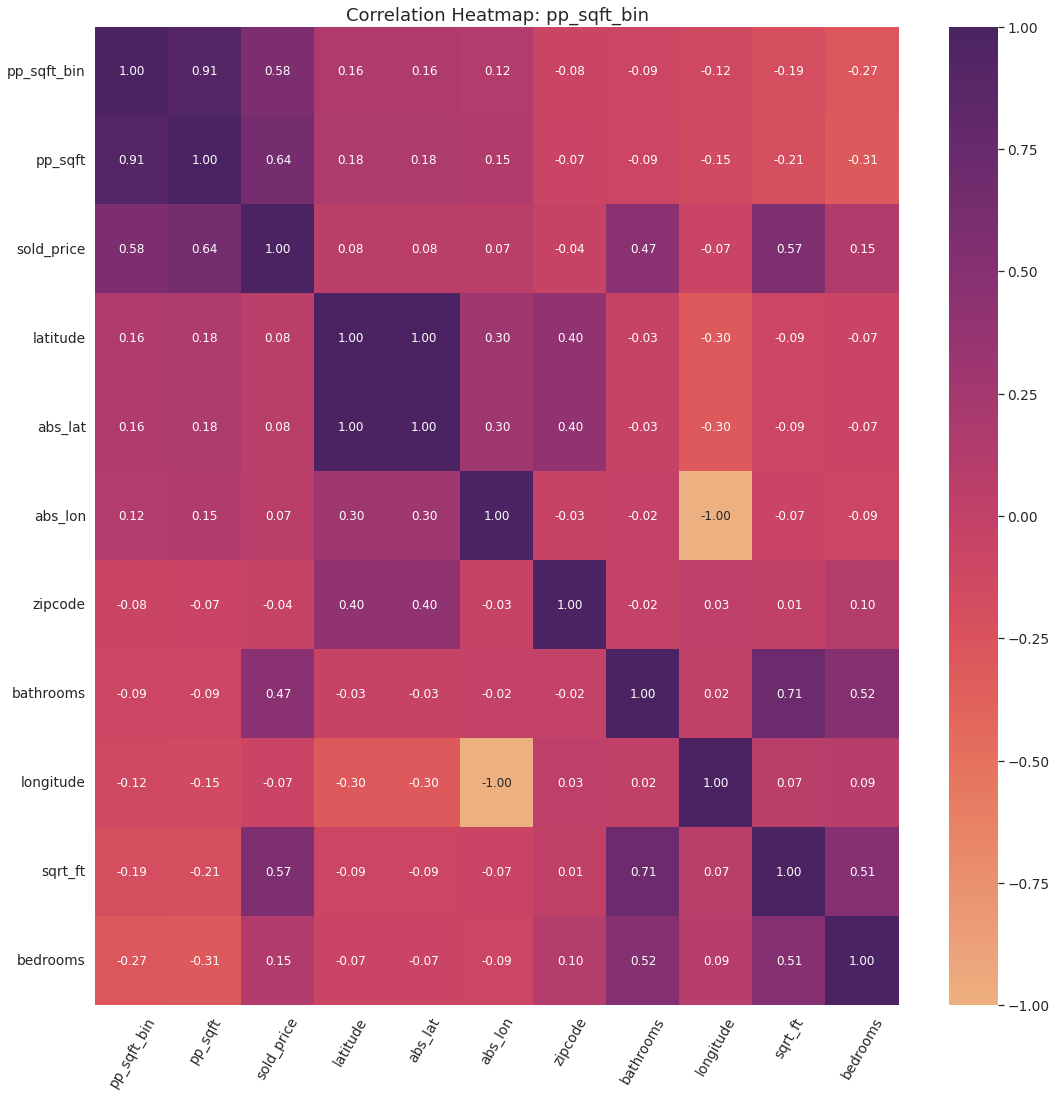

In [61]:
# pp_sqft_bin correlations 
corrmat = binned_df.corr()
cols = corrmat.nlargest(len(binned_df.columns), 'pp_sqft_bin')['pp_sqft_bin'].index
cm = np.corrcoef(binned_df[cols].values.T)

# Heatmap
sns.set(font='sans-serif', font_scale=1.25)
plt.figure(figsize=(18, 18))
ax = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 12}, cmap="flare")
ax.set_yticklabels(cols.values, rotation=0)
ax.set_xticklabels(cols.values, rotation=60)
ax.set_title("Correlation Heatmap: pp_sqft_bin", fontsize=18)

Text(0.5, 1.0, 'Correlation Heatmap: sold_price')

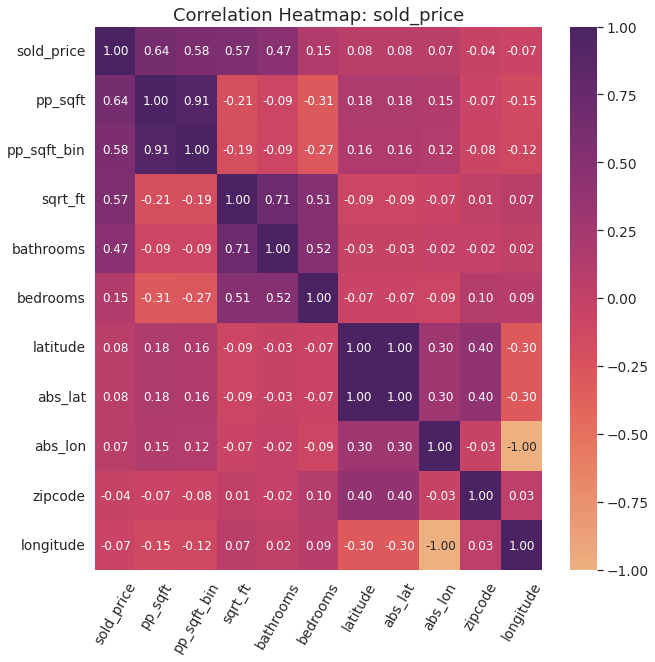

In [62]:
# sold_price correlations
corrmat = binned_df.corr()
cols = corrmat.nlargest(len(binned_df.columns), 'sold_price')['sold_price'].index
cm = np.corrcoef(binned_df[cols].values.T)

# Heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 12}, cmap="flare")
ax.set_yticklabels(cols.values, rotation=0)
ax.set_xticklabels(cols.values, rotation=60)
ax.set_title("Correlation Heatmap: sold_price", fontsize=18)

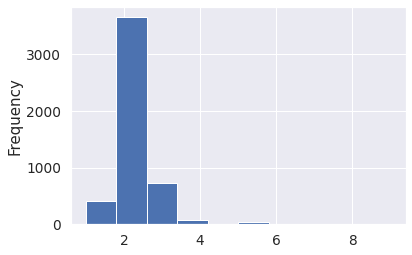

In [63]:
# print(binned_df.pp_sqft_bin.value_counts().sort_index())
binned_df.pp_sqft_bin.plot(kind="hist")

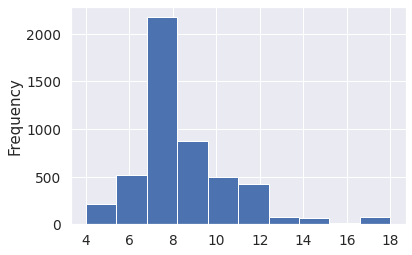

In [64]:
# print(binned_df2.pp_sqft_bin.value_counts().sort_index())
binned_df2.pp_sqft_bin.plot(kind="hist")

In [65]:
print(len(binned_df.pp_sqft_bin.unique()))
print(len(binned_df2.pp_sqft_bin.unique()))

9
15


### Classifier

In [66]:
modelling_df = binned_df2.copy()
class_features, class_target = ["abs_lon", "abs_lat"], ["pp_sqft_bin"]
X_train, y_train, X_test, y_test = train_test_split(modelling_df, class_features, class_target)

[18]


In [67]:
knn = KNNClassifier()
knn.fit(X_train, y_train)
knn_yhat = knn.predict(X_test, K=10)
knn_acc = acc(y_test, knn_yhat)
knn_acc

0.25203252032520324

### Creating a dataframe with our new feature



In [68]:
# Create a new df with the predictions as a feature
new_df = df.copy()
new_df['cls'] = modelling_df[class_target]

In [69]:
# Removing a null value that randomly appeared before the demo
new_df[new_df.cls.isnull()]
new_df = new_df.dropna()

### Regressor

In [176]:
reg_features, reg_target = ["cls", "sqrt_ft", "bathrooms"], ["sold_price"]

In [177]:
X_train_reg, y_train_reg, X_test_reg, y_test_reg = train_test_split(new_df, reg_features, reg_target)

[185]


In [178]:
mreg = OurLinearRegression()
mreg.fit(X_train_reg, y_train_reg, alpha=1e-12, epochs=2e5)
y_hat_reg = mreg.predict(X_test_reg)
R2(y_test_reg, y_hat_reg)

0.2778617163500632

## Demo

In [2]:
def demo(classifier, regressor, addr, feature_array):
    coords = abs(get_coords(addr))
    pred_bin = classifier.predict(coords, K=25)
    to_reg = [int(pred_bin)] + feature_array
    pred_val = regressor.predict(to_reg)
    return pred_bin, round(pred_val, 2)

In [ ]:
# filtered_df = df.loc[df['Symbol'] == 'A99']
# filtered_df = df.loc[df['Symbol'].isin('A99')]